# Basics of FFT estimators for P1D (new version, without rfft)

This is a toy example, but to make it easier to connect with reality I will try to use units and values similars to what we believe is the real universe. 

We don't need to specify units in this toy example, but I will use values that would roughly correspond to Mpc in a real data analysis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Define the FFT grid

In [2]:
# number of pixels (powers of two are usually good)
N=2**8
# number of Fourier modes
#NF=int(N/2+1)
# skewer length
L=500
# pixel width 
dx = L/N
print('dx=',dx)
# Wavenumbers for the generated Fourier modes, specified by the grid length and resolution
q = np.fft.fftfreq(N)*2*np.pi/dx

dx= 1.953125


In [3]:
print('Nk =',q.shape)
print('Delta k =',q[1],2*np.pi/L)
print('k_Ny = ',-q[N//2],np.pi/dx)

Nk = (256,)
Delta k = 0.012566370614359173 0.012566370614359173
k_Ny =  1.6084954386379742 1.6084954386379742


Setup the random number generator

In [4]:
# random seed
seed=1234
# setup random number generator using seed
gen = np.random.default_rng(seed)
# test the random number generator
gen.normal(size=1)

array([-1.60383681])

### Input power spectrum

The power spectrum will deteremine how much structure is there as a funciton of scale

In [5]:
def true_p1d(k,P0=1.0,k0=1,kF=10):
    """Define here your favorite power spectrum."""

    if np.any(k<0):
        raise ValueError('true_p1d should only receive non-zero values of k')
    
    # white noise at low-k
    P = P0*np.ones_like(k)

    # small enhancement at low-k
    P *= (1+k/k0)
    
    # suppressed at k0
    P *= 1/(1+(k/k0)**2)

    # further suppressed with a Gaussian at kF=10
    P *= np.exp(-(k/kF)**2)
    
    return P

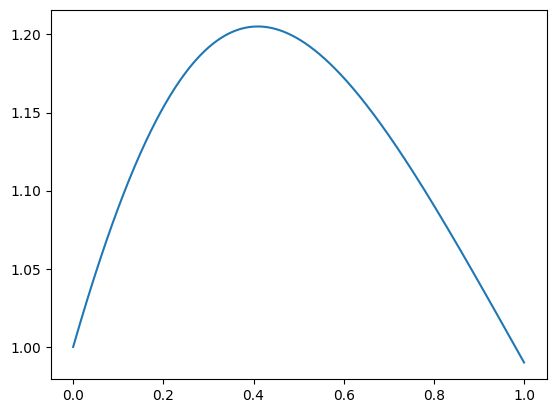

In [6]:
# linear plot
kplot=np.linspace(0,1,1000)
plt.plot(kplot,true_p1d(kplot))

(0.0001, 2)

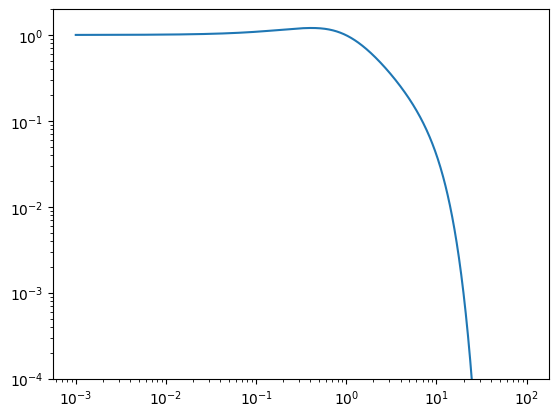

In [7]:
# log spacing plot
kplot=np.logspace(-3,2,1000)
plt.loglog(kplot,true_p1d(kplot))
plt.ylim(0.0001,2)

### Generate random Gaussian skewers

Start by generating random Fourier modes

In [8]:
def get_gaussian_modes(gen,new_seed=None,debug=False):
    """Generate Gaussian random numbers for the Fourier modes of the grid."""

    if new_seed:
        new_gen = np.random.default_rng(new_seed)
    else:
        new_gen = gen

    if debug:
        print(new_gen.normal(size=1))
    
    # get power evaluated at each k (with correct normalisation, based on my notes)
    P = true_p1d(np.abs(q)) 
    norm = (N/dx)
    P *= norm

    # generate random Fourier modes
    modes = np.empty(N, dtype=complex)
    modes[:].real = new_gen.normal(size=N)
    modes[:].imag = new_gen.normal(size=N)
    
    # normalize to desired power (and enforce real for i=0, i=NF-1)
    modes[0] = modes[0].real * np.sqrt(P[0])
    modes[(N+1)//2] = modes[(N+1)//2].real * np.sqrt(P[(N+1)//2])
    modes[1:(N+1)//2] *= np.sqrt(0.5*P[1:(N+1)//2])    

    # remember that F(-k) = F^*(k)
    modes[(N+1)//2+1:]=np.conj(modes[1:(N+1)//2])[::-1]
    #modes[(N+1)//2+1:] *= np.sqrt(0.5*P[(N+1)//2+1:])    
    
    return modes

In [9]:
modes=get_gaussian_modes(gen,new_seed=1,debug=True)

[0.34558419]


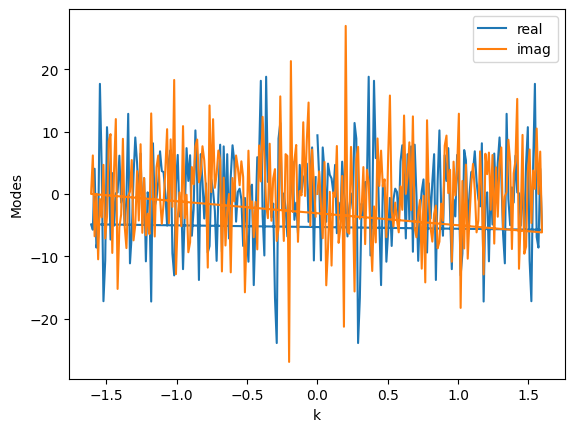

In [10]:
plt.plot(q,modes.real,label='real')
plt.plot(q,modes.imag,label='imag')
plt.xlabel('k')
plt.ylabel('Modes')
#plt.title('Gaussian Fourier modes (real part)')
plt.legend()

### Run on multiple skewers

The squared amplitude of the Fourier modes should (on average!) agree with the input power spectrum

In [11]:
# generate many random fields
Nsk=1000000
gen = np.random.default_rng(seed)

In [12]:
# measure P1D and variance
mean_p1d=np.zeros(N)
var_p1d=np.zeros(N)
for i in range(Nsk):
    modes=get_gaussian_modes(gen=gen,debug=False)
    p1d = abs(modes)**2
    mean_p1d += p1d
    var_p1d += p1d**2
# normalize them
mean_p1d /= Nsk
var_p1d /= Nsk
var_p1d -= mean_p1d**2
# compute error on mean
err_p1d = np.sqrt(var_p1d/Nsk)

In [13]:
# correct normalisation based on my notes
mean_p1d *= (dx/N)
err_p1d *= (dx/N)

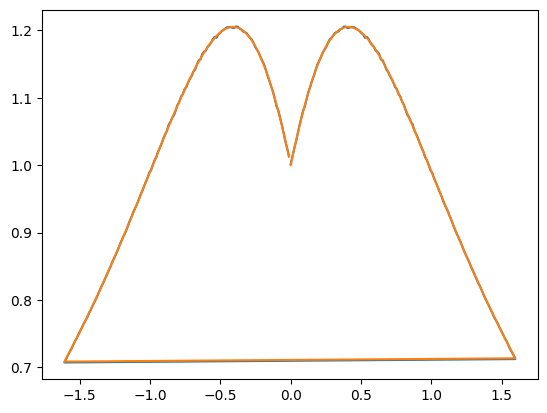

In [14]:
# evaluate true P1D for the plot
true=true_p1d(np.abs(q))
plt.plot(q,mean_p1d)
plt.plot(q,true)

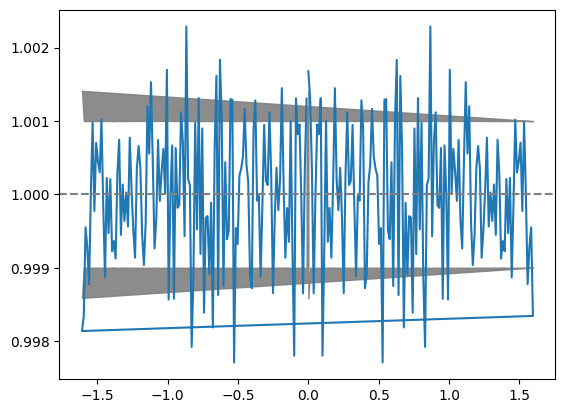

In [15]:
plt.plot(q,mean_p1d/true)
plt.fill_between(q,1-err_p1d/true,1+err_p1d/true,alpha=0.9,color='gray')
plt.axhline(y=1,ls='--',color='gray')

### Test now going back and forth with FFT

In [16]:
def get_gaussian_field(gen,new_seed=None,debug=False):
    """Generate a set of random Fourier modes, and use them to get a field"""
    modes = get_gaussian_modes(gen=gen,new_seed=new_seed,debug=debug)
    deltas = np.fft.ifft(modes).real
    return deltas

In [17]:
modes = modes=get_gaussian_modes(gen=gen,new_seed=seed,debug=True)

[-1.60383681]


In [18]:
delta = np.fft.ifft(modes).real

In [19]:
# Test that we recover the modes
new_modes=np.fft.fft(delta)
print(max(modes-new_modes))

(4.6629367034256575e-15-1.7763568394002505e-15j)


In [20]:
new_delta=np.fft.ifft(new_modes).real
print(max(delta-new_delta))

4.440892098500626e-16


### Apply a mask (same for all skewers) and redo the plots

In [21]:
mask=np.ones(N)
# will mask a small fraction of the data
Nbad=N//5
mask[Nbad:2*Nbad]=0
#mask[6*Nbad:7*Nbad]=0

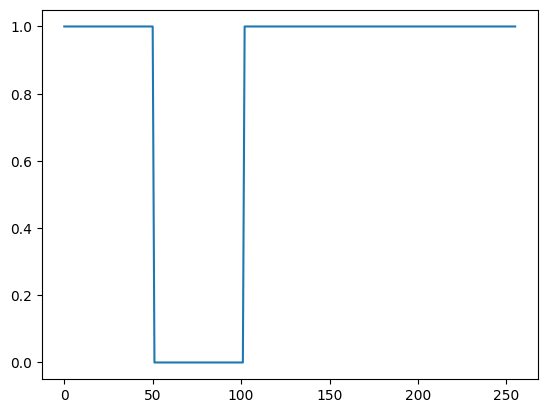

In [22]:
plt.plot(mask)

In [23]:
# FFT the mask, and square it
w_m = np.fft.fft(mask)
w2_m = abs(w_m)**2

(0.0, 0.5)

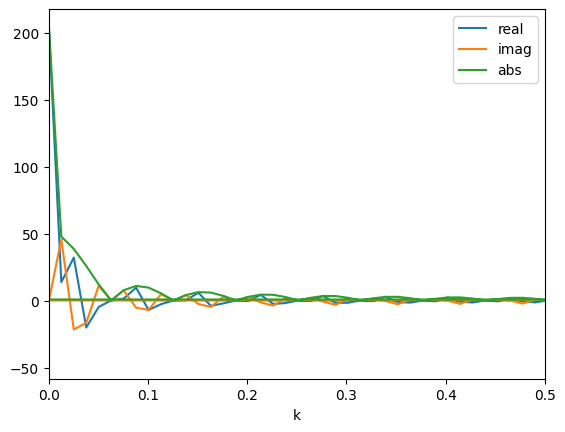

In [24]:
plt.plot(q,w_m.real,label='real')
plt.plot(q,w_m.imag,label='imag')
plt.plot(q,np.sqrt(w2_m),label='abs')
plt.legend()
plt.xlabel('k')
plt.xlim([0,0.5])

In [25]:
# reset seed again
gen = np.random.default_rng(seed)
# measure P1D and variance
mean_masked_p1d=np.zeros(N)
var_masked_p1d=np.zeros(N)
for i in range(Nsk):
    # recompute modes
    modes=get_gaussian_modes(gen=gen,debug=False)    
    # FFT the modes to obtain the skewers
    deltas = np.fft.ifft(modes).real
    # mask the skewers
    deltas *= mask
    # and FFT again to obtain masked modes
    masked_modes=np.fft.fft(deltas)
    p1d = abs(masked_modes)**2
    mean_masked_p1d += p1d
    var_masked_p1d += p1d**2
# normalize them
mean_masked_p1d /= Nsk
var_masked_p1d /= Nsk
var_masked_p1d -= mean_masked_p1d**2
# compute error on mean
err_masked_p1d = np.sqrt(var_masked_p1d/Nsk)
# correct normalisation based on my notes
mean_masked_p1d *= (dx/N)
err_masked_p1d *= (dx/N)

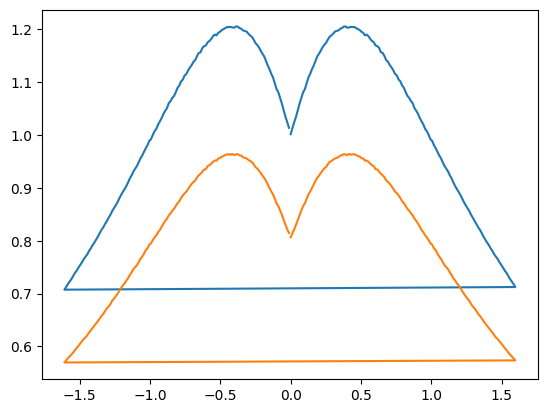

In [26]:
plt.plot(q,mean_p1d)
plt.plot(q,mean_masked_p1d)

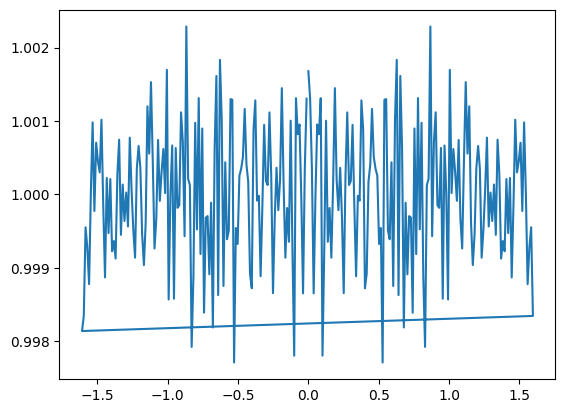

In [27]:
plt.plot(q,mean_p1d/true)
#plt.plot(q,mean_masked_p1d/true)

In [28]:
norm=np.mean(mean_masked_p1d/mean_p1d)
print(norm)

0.8008722185551067


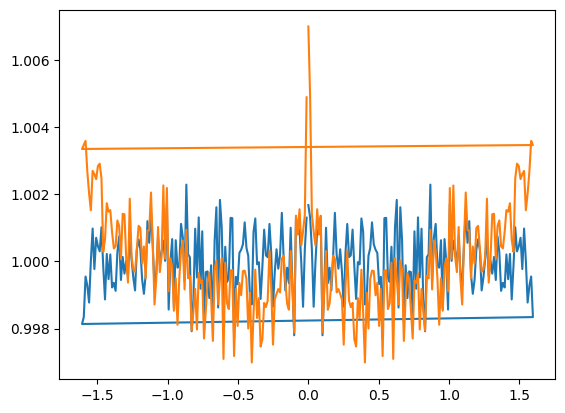

In [29]:
plt.plot(q,mean_p1d/true)
plt.plot(q,mean_masked_p1d/true/norm)

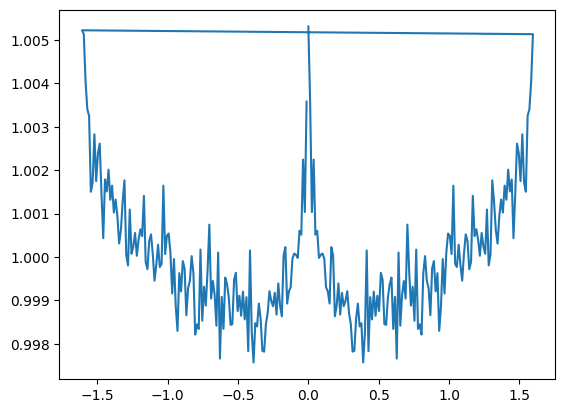

In [30]:
plt.plot(q,mean_masked_p1d/mean_p1d/norm)

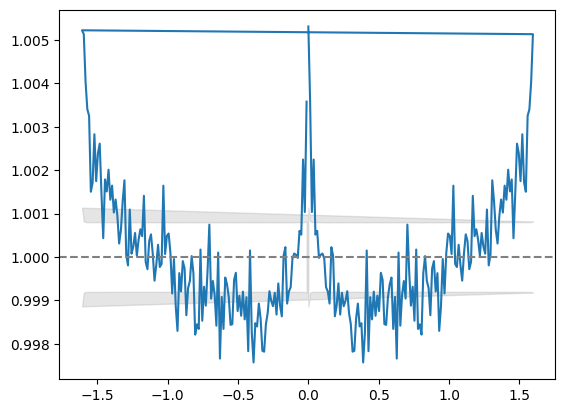

In [31]:
plt.plot(q,mean_masked_p1d/mean_p1d/norm)
plt.fill_between(q,1-err_masked_p1d/true,1+err_masked_p1d/true,alpha=0.2,color='gray')
plt.axhline(y=1,ls='--',color='gray')